# Prediction of Individuals in Tech Seeking Mental Health Intervention

In this notebook 


## Environment Setting

In [197]:
## Data cleaning and manipulation
import pandas as pd
import numpy as np
import klib
import miceforest as mf

#Env
import warnings

## Modeling and Data Processing libraries
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix, recall_score,f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SequentialFeatureSelector

##Visualizatin Libraries
import matplotlib.pyplot as plt
import altair as alt
from IPython.display import HTML
import seaborn as sns

#Setting environment variables
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_info_columns', 50)
pd.set_option('display.max_columns', 50)

alt.data_transformers.disable_max_rows() #Remove 5000 rows limitations
rnd=289

## Dataset Information
This dataset is from a 2014 survey that measures attitudes towards mental health and frequency of mental health disorders in the tech workplace.

Source: https://www.kaggle.com/osmi/mental-health-in-tech-survey

## Data Loading

First, let's load the data

In [198]:
#loading the data file
df_mental_health = pd.read_csv('data/survey.csv')

#Check the datashape
df_mental_health.shape

(1259, 27)

Since we don't want our testing data to influence any of our decisions, let's get our testing data and lock it out before we do any of the EDA.

In [199]:
train_df, test_df = train_test_split(df_mental_health,test_size=0.3)

## Exploratory Data Analysis

In [200]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 544 to 296
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  881 non-null    object
 1   Age                        881 non-null    int64 
 2   Gender                     881 non-null    object
 3   Country                    881 non-null    object
 4   state                      521 non-null    object
 5   self_employed              868 non-null    object
 6   family_history             881 non-null    object
 7   treatment                  881 non-null    object
 8   work_interfere             691 non-null    object
 9   no_employees               881 non-null    object
 10  remote_work                881 non-null    object
 11  tech_company               881 non-null    object
 12  benefits                   881 non-null    object
 13  care_options               881 non-null    object
 14  wellness

All columns are categorical except for Age. 

Timestamp is encoded as object as well but we are not concerned with the time as all observations belong to a single survey and each subject has one observation. So we are going to drop this feature.

We have missing values in the following columns:
- State
- Work_interfere
- Self_employed
- Comments 

We'll look more closely at the missing data later to decide on the best approach to handle them.

### Numerical Columns

                 Age
count         881.00
mean    113507410.14
std    3369085601.53
min             5.00
25%            27.00
50%            31.00
75%            36.00
max   99999999999.00


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

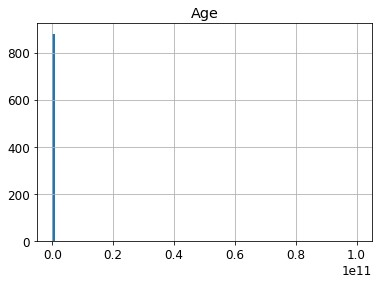

In [201]:
print(train_df.describe())
train_df.hist(bins=100)

Age column has negative and extreme values. We'll take care of those in the data cleansing stage

### Categorical Columns

In [202]:
train_df.describe(include=['object'])

,Timestamp,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
count,881,881,881,521,868,881,881,691,881,881,881,881,881,881,881,881,881,881,881,881,881,881,881,881,881,112
unique,878,41,38,43,2,2,2,4,6,2,2,3,3,3,3,3,5,3,3,3,3,3,3,3,2,109
top,2014-08-27 12:43:28,Male,United States,CA,No,No,Yes,Sometimes,26-100,No,Yes,Yes,No,No,No,Don't know,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,410,524,93,764,532,441,325,205,625,715,330,340,592,449,569,380,341,634,557,370,715,372,402,745,4


Some findings from the table above:
- Gender has 42 unique values. The mode is Male with almost half the observations (485 out of the 1007).
- Country has 42 unique values.  The mode is United States with more than 60% of the observations (622 out of 1007).

We'll take a closer look later

Let's look at a sample of the data

In [203]:
train_df.sample(5)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
969,2014-08-29 06:42:57,33,female,United Kingdom,NaN,Yes,No,Yes,Sometimes,1-5,Yes,Yes,No,Yes,Yes,Yes,Yes,Very easy,No,No,Some of them,Yes,No,No,Don't know,No,NaN
856,2014-08-28 17:01:25,51,Male,United States,MN,No,No,No,Never,More than 1000,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Very easy,No,No,Yes,Yes,No,No,Yes,No,NaN
1008,2014-08-29 09:42:23,39,M,United States,IN,No,Yes,Yes,Sometimes,6-25,Yes,Yes,No,Yes,No,No,Yes,Somewhat easy,No,No,Some of them,Yes,Maybe,Yes,Yes,No,NaN
1076,2014-08-29 14:31:00,43,Male,United States,VA,Yes,Yes,Yes,Sometimes,1-5,Yes,Yes,Yes,Not sure,No,Don't know,Don't know,Don't know,Maybe,Maybe,Some of them,Some of them,No,Maybe,Don't know,No,This survey was tough as a self-employed indiv...
1025,2014-08-29 10:16:45,42,M,United States,CA,No,Yes,Yes,Sometimes,6-25,Yes,Yes,Don't know,No,No,Don't know,Don't know,Don't know,Maybe,Maybe,Some of them,Some of them,No,No,Don't know,No,NaN


## Graphical EDA

### Categorical Columns

Now we'll look at columns with many unique values and see if we need all those categories.

In [204]:
cat_long_columns=['Gender','Country','state']
alt.Chart(train_df).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='ordinal'),
    alt.Y('count()', stack=None),
    alt.Color('treatment')
).properties(
    height=200
).repeat(
    cat_long_columns,
    columns=1
)

alt.RepeatChart(...)

At this point we can see that 
- Gender will need to be collapsed to Male/Female/Others.
- States are only collected for some observations. (the ones that are in the US). so we'll need to drop this column.
- The United States is over represented in the dataset with approx. 350 observations. so we'll drop this column too.

In [205]:
cat_columns = [c for c in train_df.select_dtypes(include='object') if train_df[c].nunique() <= 10]

alt.Chart(train_df).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='nominal'),
    alt.Y('count()', stack=None),
    alt.Color('treatment'),
).properties(
    height=200,
    width = 300,
).repeat(
    cat_columns,
    columns=3
)

alt.RepeatChart(...)

### Numerical

Finally, We'll check the Age column - the only numerical column -  in the dataset

In [206]:
alt.Chart(train_df).mark_bar(opacity=0.6).encode(
    alt.X('Age:Q'),
    alt.Y('count()'),
    alt.Color('treatment')
)

alt.Chart(...)

As we've seen there are few data entry errors. We'll need to remove those values and then handle them in the imputation stage.

**EDA Conclusions**

- 

## Data Cleansing

First we'll drop the columns that are irrelevent to the analysis

In [207]:
train_df.drop(columns=['Timestamp','state','Country','comments'],inplace=True)
test_df.drop(columns=['Timestamp','state','Country','comments'],inplace=True)

Then we clean the column names

In [208]:
klib.clean_column_names(train_df,hints=False)
klib.clean_column_names(test_df,hints=False)

,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
1042,40,M,No,Yes,Yes,Sometimes,More than 1000,Yes,Yes,Yes,Yes,No,Yes,Don't know,Don't know,Yes,No,No,No,No,Maybe,Don't know,No
1084,32,male,No,Yes,Yes,Sometimes,1-5,No,No,Yes,Yes,Yes,Yes,Yes,Somewhat easy,Maybe,Maybe,Some of them,Some of them,No,Maybe,No,No
1225,23,female,No,No,Yes,Rarely,26-100,No,Yes,No,Yes,Yes,No,Don't know,Don't know,No,No,Yes,Some of them,No,Maybe,Don't know,No
790,29,M,No,No,No,Rarely,100-500,No,Yes,Don't know,Not sure,No,No,Don't know,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Don't know,Yes
908,36,Male,No,No,Yes,Rarely,500-1000,Yes,Yes,Yes,Yes,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,Maybe,Don't know,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,37,Male,No,No,No,Sometimes,6-25,No,Yes,No,No,No,No,Don't know,Very difficult,Yes,Maybe,Some of them,No,No,Maybe,No,No
396,48,M,No,No,No,NaN,26-100,No,Yes,Don't know,No,No,No,Don't know,Don't know,Maybe,Maybe,No,No,No,No,No,No
1235,23,Male,No,No,Yes,Often,26-100,No,Yes,Yes,Yes,Yes,Don't know,Don't know,Don't know,Maybe,No,Yes,Some of them,No,No,Don't know,No
60,44,Male,No,Yes,Yes,Sometimes,More than 1000,No,No,Yes,No,No,Don't know,Don't know,Don't know,Yes,Maybe,Some of them,No,No,Maybe,Don't know,Yes


We'll remove the data entry errors in the Age column

In [209]:
train_df['age'].where(train_df['age'] > 18, np.nan, inplace=True)
train_df['age'].where(train_df['age'] < 100, np.nan, inplace=True)

test_df['age'].where(test_df['age'] > 18, np.nan, inplace=True)
test_df['age'].where(test_df['age'] < 100, np.nan, inplace=True)

Collapse the Gender column unique values into Male/Female/Others

In [210]:
male = ['M', 'Male', 'male', 'm', 'maile',
       'Mal', 'Make', 'Male ', 'Man', 'msle', 'Mail', 
       'Malr','ostensibly male, unsure what that really means','Cis Male','Male (CIS)','cis male','Cis Man']
female = ['Female', 'female', 'F','Woman', 'f', 
          'Femake', 'woman', 'Female ', 
          'Female (cis)', 'femail','Cis Female','cis-female/femme']
other = ['Male-ish', 'Trans-female', 'something kinda male?',
       'queer/she/they','non-binary', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Androgyne', 'Agender',
        'Guy (-ish) ^_^', 'male leaning androgynous',
       'Trans woman',  'Neuter', 'Female (trans)',
       'queer', 'A little about you','p']

train_df.replace(male,"Male", inplace=True)
train_df.replace(female,"Female",inplace=True)
train_df.replace(other,"Other", inplace=True)

test_df.replace(male,"Male", inplace=True)
test_df.replace(female,"Female",inplace=True)
test_df.replace(other,"Other", inplace=True)
test_df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

Check for Missing Values

GridSpec(6, 6)

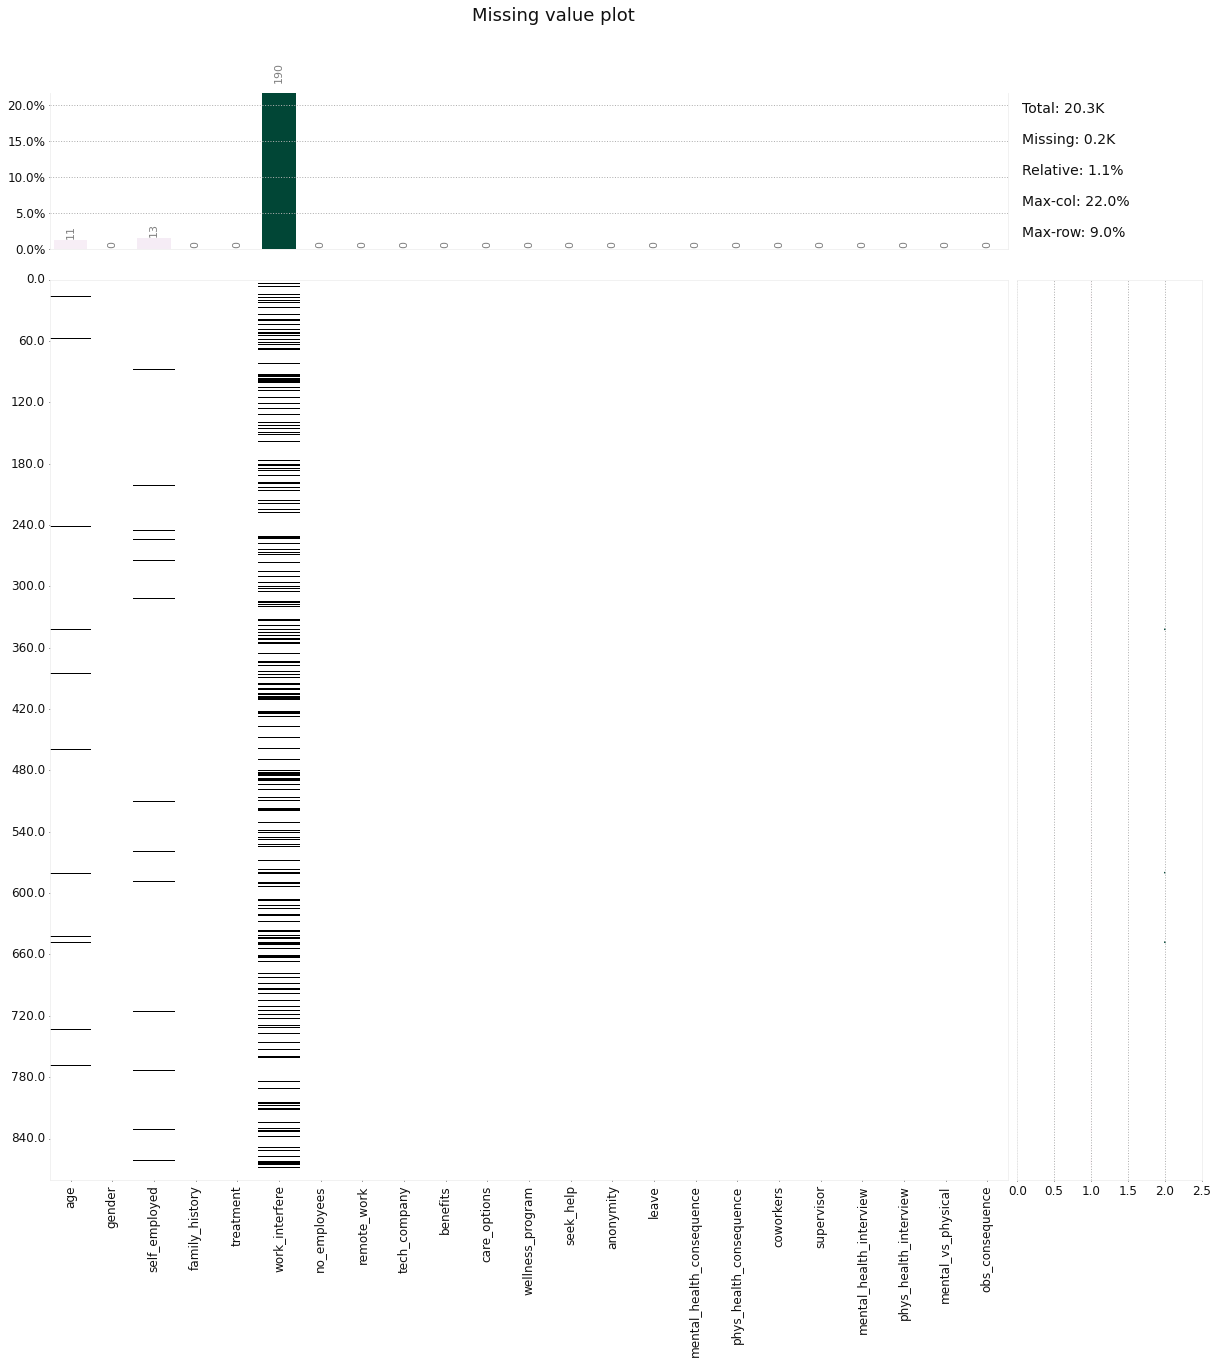

In [211]:
klib.missingval_plot(train_df)

Nowe we have some missing values in the following columns:
- age
- self_employed
- work_interfere

We'll impute these data points in the pipelines later. The work_interfere specifically looks like a strong predictor from our EDA

- Baseline
- Explain scoring metric
- Encoding
- Imputing
- Scaling
- Col Transformers
    - Nominal
    - Ordinal
    - Numeric
- Pipeline
- Hyperparams
- Add Models to the pipeline
    - Optimize for recall

## Data Preprocessing

Now, we'll start preparing the data to be in the proper format for the machine learning models.

First we split and recode the target column in both training and test dataframes

In [212]:
X_train = train_df.drop(columns=['treatment'])
y_train = train_df['treatment']

X_test = test_df.drop(columns=['treatment'])
y_test = test_df['treatment']

#X_train.replace(np.nan,'Not mentioned',inplace=True)
#X_test.replace(np.nan,'Not mentioned',inplace=True)

y_train.replace('No',0,inplace=True)
y_train.replace('Yes',1,inplace=True)

y_test.replace('No',0,inplace=True)
y_test.replace('Yes',1,inplace=True)

Let's make sure that we have outcome balanced classes

<AxesSubplot:>

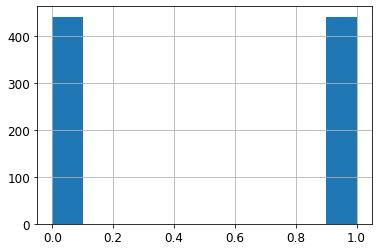

In [213]:
y_train.hist()

Good our classes are balanced so we don't need to treat that in the training

Next, we define the numeric, nominal, ordinal features.
For the ordinal features we'll also define the order of the values.

In [214]:
numeric_features = ['age']
categ_features = ['care_options', 'wellness_program', 'mental_vs_physical', 'remote_work', 
                    'anonymity', 'obs_consequence', 'gender', 'self_employed', 'tech_company', 'benefits',
                    'family_history', 'seek_help','mental_health_consequence', 'phys_health_consequence',
                    'mental_health_interview', 'phys_health_interview','coworkers', 'supervisor',
                    'leave','no_employees','work_interfere']
nominal_features = ['care_options', 'wellness_program', 'mental_vs_physical', 'remote_work', 
                    'anonymity', 'obs_consequence', 'gender', 'self_employed', 'tech_company', 'benefits',
                    'family_history', 'seek_help']
ordinal_3_maybe_features = ['mental_health_consequence', 'phys_health_consequence',
                            'mental_health_interview', 'phys_health_interview']
ordinal_3_some_features = ['coworkers', 'supervisor']
ordinal_leave_features = ['leave']
ordinal_no_employees_features = ['no_employees']
ordinal_work_interfere_features = ['work_interfere']

order_no_employees = ['1-5','6-25','26-100','100-500','500-1000','More than 1000']

order_3_maybe = ['No','Maybe','Yes']
order_3_some = ['No','Some of them','Yes']
order_leave = ['Very easy','Somewhat easy','Don\'t know','Somewhat difficult','Very difficult']
order_work_interfere = ['Not mentioned','Never','Rarely','Sometimes','Often']

feature_names = numeric_features + nominal_features + ordinal_3_maybe_features + ordinal_3_some_features + ordinal_leave_features + ordinal_no_employees_features + ordinal_work_interfere_features

Finally we apply transformations on the different columns.
- Numeric columns: imputed and scaled
- Ordinal: imputed and encoded using the appropriate OrdinalEncoder
- Nominal: imputed and encoded using one-hot-encoder

and create the column transformer.

In [215]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

nominal_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop='if_binary')
)

ordinal_3_maybe_features_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[order_3_maybe,order_3_maybe,order_3_maybe,order_3_maybe])
)

ordinal_3_some_features_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[order_3_some,order_3_some])
)

ordinal_leave_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[order_leave])
)

ordinal_no_employees_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[order_no_employees])
)

ordinal_work_interfere_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='Not mentioned'),
    OrdinalEncoder(categories=[order_work_interfere])
)

col_transformer = make_column_transformer(
    (numeric_transformer, numeric_features), 
    (nominal_transformer, nominal_features),
    (ordinal_3_maybe_features_transformer,ordinal_3_maybe_features),
    (ordinal_3_some_features_transformer, ordinal_3_some_features),
    (ordinal_leave_transformer,ordinal_leave_features),
    (ordinal_no_employees_transformer,ordinal_no_employees_features),
    (ordinal_work_interfere_transformer,ordinal_work_interfere_features),
    remainder='drop',
)

## Helper Functions

In [216]:
# create an empty dataframe to store the scores for various classification algorithms
score_card = pd.DataFrame(columns=['Model', 'Recall Score', 'f1-score']) 


def update_score_card(model_name,y_test,y_pred):
    
    global score_card
    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card = score_card.append({'Model': model_name,
                                    'Recall Score': recall_score(y_test, y_pred),
                                    'f1-score': f1_score(y_test, y_pred)}, 
                                    ignore_index = True)
    return(score_card)

from sklearn.base import TransformerMixin, BaseEstimator

class debug(BaseEstimator, TransformerMixin):
    def transform(self, X):
        print(X.shape)
        print(np.count_nonzero(X == 0))
        print(np.count_nonzero(X == 1))
        print(np.count_nonzero(X == 2))
        print(np.count_nonzero(X == 3))
        print(np.count_nonzero(X == 4))
        return X
    
    def fit(self, X, y=None, **fit_params):
        return self

Now we are ready to train the machine learning models. 

But before we start we need to establish a baseline for our models. We'll using a DummyClassifier to establish this baseline.

### Dummy Classifier

In [217]:
dummy_pipe = make_pipeline(col_transformer,DummyClassifier(strategy='prior'))
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                   

In [218]:
print(dummy_pipe.score(X_train, y_train))

dummy_scores_df = pd.DataFrame(cross_validate(dummy_pipe, X_train, y_train, cv=5,return_train_score=True))

dummy_scores_df

0.5005675368898979


,fit_time,score_time,test_score,train_score
0,0.01,0.01,0.50,0.50
1,0.01,0.00,0.50,0.50
2,0.01,0.00,0.50,0.50
3,0.01,0.00,0.50,0.50
4,0.01,0.00,0.50,0.50


## Model Selection

In this section, we will go through different classifier models with RandomSearch to tune the different hyperparameters of each classification algorithm.

### SVC

#### Model Training

In [219]:
#creating the pipeline
pipe = make_pipeline(col_transformer, SVC())
#setting hyperparameters grid
param_grid = {
    "svc__degree":[2,3],
    "svc__gamma":[0.001,0.01,0.1,0.5,1,5],
    "svc__C": [0.8,0.9, 1.0,1.1, 1.2],
    "svc__kernel":['rbf','linear','poly','sigmoid'],
}

In [220]:
from sklearn.metrics import recall_score
svc_random_search = RandomizedSearchCV(pipe, param_grid, cv=10, n_jobs=-1, return_train_score=True,scoring=['f1','recall'],refit='f1',verbose=0)
svc_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                            

##### Model Training Score

In [221]:
HTML(pd.DataFrame(svc_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall",
 "mean_test_f1", "mean_train_f1"]].sort_values(by=['mean_test_f1','mean_test_recall'], ascending=False).head(5).to_html())

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1
1,"{'svc__kernel': 'rbf', 'svc__gamma': 0.01, 'svc__degree': 3, 'svc__C': 1.1}",0.92,0.93,0.85,0.86
4,"{'svc__kernel': 'sigmoid', 'svc__gamma': 0.001, 'svc__degree': 2, 'svc__C': 0.9}",0.92,0.92,0.85,0.86
2,"{'svc__kernel': 'sigmoid', 'svc__gamma': 0.01, 'svc__degree': 2, 'svc__C': 1.2}",0.91,0.92,0.85,0.86
6,"{'svc__kernel': 'linear', 'svc__gamma': 0.01, 'svc__degree': 3, 'svc__C': 1.2}",0.88,0.90,0.84,0.85
7,"{'svc__kernel': 'poly', 'svc__gamma': 0.1, 'svc__degree': 2, 'svc__C': 1.2}",0.83,0.94,0.80,0.90


In [222]:
#predict the results
svc_predictions = svc_random_search.predict(X_test)
# add to the score card
update_score_card("SVC",y_test,svc_predictions)
#create the confusion matrix
svc_cm = confusion_matrix(y_test, svc_predictions)


#### Model Validation

##### Model Test Scores

In [223]:
sv_cr = classification_report(
        y_test,
        svc_random_search.predict(X_test),
        target_names=["no treatment", "treatment"]
    )

print(sv_cr)

              precision    recall  f1-score   support

no treatment       0.88      0.73      0.80       182
   treatment       0.78      0.91      0.84       196

    accuracy                           0.82       378
   macro avg       0.83      0.82      0.82       378
weighted avg       0.83      0.82      0.82       378



##### Model Confusion Matrix

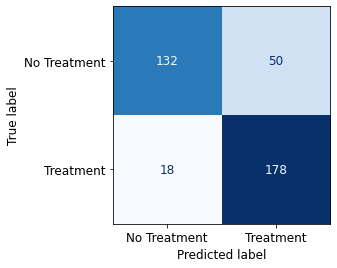

In [224]:
plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(svc_cm, display_labels=["No Treatment", "Treatment"]).plot(cmap=plt.cm.Blues,colorbar=False)

In [225]:
svc_random_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                   

### Logistic Regression

#### Model Training

In [226]:
pipe_logis = Pipeline(steps=[('col_trans',col_transformer),('lr',LogisticRegression())])

logis_param_grid = {"lr__C" :10.0**np.arange(-6,2,1)}

In [227]:
logis_random_search = RandomizedSearchCV(pipe_logis, logis_param_grid, cv=10, n_jobs=-1, return_train_score=True,scoring=['f1','recall'], refit='f1')
logis_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                    

##### Model Training Score

In [228]:
HTML(pd.DataFrame(logis_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall",
 "mean_test_f1", "mean_train_f1"]].sort_values(by=['mean_test_f1','mean_test_recall'], ascending=False).head(10).to_html())

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1
2,{'lr__C': 0.0001},0.90,0.91,0.85,0.85
3,{'lr__C': 0.001},0.89,0.90,0.84,0.85
4,{'lr__C': 0.01},0.88,0.90,0.84,0.85
1,{'lr__C': 1e-05},0.94,0.95,0.84,0.84
5,{'lr__C': 0.1},0.86,0.89,0.83,0.85
7,{'lr__C': 10.0},0.85,0.87,0.82,0.84
6,{'lr__C': 1.0},0.85,0.87,0.82,0.84
0,{'lr__C': 1e-06},1.00,1.00,0.72,0.73


#### Model Validation

##### Model Score

In [229]:
from sklearn.metrics import classification_report
logis_cr = classification_report(
        y_test,
        logis_random_search.predict(X_test),
        target_names=["no treatment", "treatment"]
    )
print(logis_cr)

              precision    recall  f1-score   support

no treatment       0.86      0.74      0.80       182
   treatment       0.78      0.89      0.84       196

    accuracy                           0.82       378
   macro avg       0.82      0.81      0.82       378
weighted avg       0.82      0.82      0.82       378



##### Model Confusion Matrix

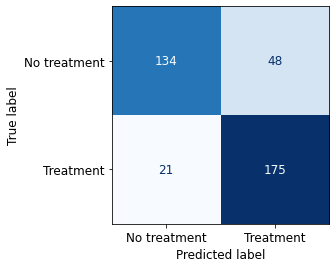

In [230]:
logis_predictions = logis_random_search.predict(X_test)
# add to the score card
update_score_card("Logistic Regression",y_test,logis_predictions)
#create and display the confusion matrix
logis_cm = confusion_matrix(y_test, logis_predictions)
plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(logis_cm, display_labels=["No treatment", "Treatment"]).plot(cmap=plt.cm.Blues,colorbar=False)

### Logistic Regression with backward feature selection

#### Model Training

In [231]:
pipe_backward = Pipeline(steps=[('col_trans', col_transformer),
    ('feature_selector',SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        direction='backward',
        n_features_to_select=5,
    )),('lr',
    LogisticRegression(max_iter=1000))]
)

logis_bfs_param_grid = {"feature_selector__n_features_to_select":[3,5,10],
                        "lr__C" :10.0**np.arange(-4,2,1)}

In [232]:
logis_bfs_random_search = RandomizedSearchCV(pipe_backward, logis_bfs_param_grid, cv=3, n_jobs=-1, return_train_score=True,scoring=['f1','recall'], refit='f1')
logis_bfs_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                     

##### Training Scores

In [233]:
HTML(pd.DataFrame(logis_bfs_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall",
 "mean_test_f1", "mean_train_f1"]].sort_values(by=['mean_test_f1','mean_test_recall'], ascending=False).head(10).to_html())

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1
7,"{'lr__C': 0.0001, 'feature_selector__n_features_to_select': 5}",0.92,0.92,0.86,0.85
6,"{'lr__C': 0.001, 'feature_selector__n_features_to_select': 5}",0.90,0.91,0.85,0.86
2,"{'lr__C': 1.0, 'feature_selector__n_features_to_select': 3}",0.90,0.91,0.85,0.85
9,"{'lr__C': 10.0, 'feature_selector__n_features_to_select': 3}",0.90,0.91,0.85,0.85
0,"{'lr__C': 0.01, 'feature_selector__n_features_to_select': 3}",0.90,0.90,0.85,0.85
3,"{'lr__C': 0.1, 'feature_selector__n_features_to_select': 3}",0.90,0.90,0.85,0.85
8,"{'lr__C': 0.001, 'feature_selector__n_features_to_select': 3}",0.90,0.90,0.85,0.85
1,"{'lr__C': 0.01, 'feature_selector__n_features_to_select': 10}",0.89,0.90,0.84,0.85
5,"{'lr__C': 0.01, 'feature_selector__n_features_to_select': 5}",0.89,0.90,0.84,0.85
4,"{'lr__C': 10.0, 'feature_selector__n_features_to_select': 10}",0.88,0.89,0.84,0.85


#### Model Validation

##### Logistic Backward Regression Score

In [234]:
from sklearn.metrics import classification_report
logis_bw_cr = classification_report(
        y_test,
        logis_bfs_random_search.predict(X_test),
        target_names=["no treatment", "treatment"]
    )
print(logis_bw_cr)

              precision    recall  f1-score   support

no treatment       0.88      0.73      0.80       182
   treatment       0.78      0.91      0.84       196

    accuracy                           0.82       378
   macro avg       0.83      0.82      0.82       378
weighted avg       0.83      0.82      0.82       378



##### Logistic Backward Regression Confusion Matrix

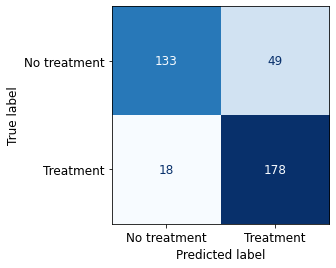

In [235]:
#Predict Results
logis_bw_predictions = logis_bfs_random_search.predict(X_test)
#Add to score card
update_score_card("Logistic Backward Regression",y_test,logis_bw_predictions)
#Get the confusion matrix
logis_bw_cm = confusion_matrix(y_test, logis_bw_predictions)
plt.rc('font', size=12) # bigger font sizes
#Print the confusion matrix
ConfusionMatrixDisplay(logis_bw_cm, display_labels=["No treatment", "Treatment"]).plot(cmap=plt.cm.Blues,colorbar=False)

### KNeighborsClassifier

#### Model Training

In [236]:
from sklearn.neighbors import KNeighborsClassifier
#Setting the pipeline
knn_pipe = Pipeline(steps=[('col_trans',col_transformer),('knn', KNeighborsClassifier(weights = 'distance'))])
#setting the hyper parameters
knn_param_grid = {'knn__n_neighbors':[1,2,3,4,5,6,7]}


In [237]:
knn_random_search = RandomizedSearchCV(knn_pipe, knn_param_grid, cv=10, n_jobs=-1, return_train_score=True,scoring=['f1','recall'],refit='f1',verbose=-1)
knn_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                    

##### Training Score

In [238]:
HTML(pd.DataFrame(knn_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall",
 "mean_test_f1", "mean_train_f1"]].sort_values(by=['mean_test_f1','mean_test_recall'], ascending=False).head(10).to_html())

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1
6,{'knn__n_neighbors': 7},0.85,1.00,0.82,1.00
4,{'knn__n_neighbors': 5},0.83,1.00,0.81,1.00
5,{'knn__n_neighbors': 6},0.84,1.00,0.81,1.00
2,{'knn__n_neighbors': 3},0.82,1.00,0.81,1.00
3,{'knn__n_neighbors': 4},0.81,1.00,0.80,1.00
1,{'knn__n_neighbors': 2},0.72,1.00,0.73,1.00
0,{'knn__n_neighbors': 1},0.72,1.00,0.73,1.00


#### KNeighbors Validation

##### Model Test Scores

In [239]:
knn_cr = classification_report(
        y_test,
        knn_random_search.predict(X_test),
        target_names=["no treatment", "treatment"]
    )
print(knn_cr)

              precision    recall  f1-score   support

no treatment       0.81      0.75      0.78       182
   treatment       0.78      0.84      0.81       196

    accuracy                           0.80       378
   macro avg       0.80      0.79      0.80       378
weighted avg       0.80      0.80      0.80       378



##### Model Confusion Matrix

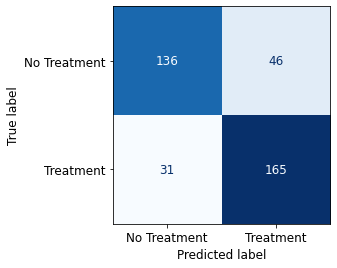

In [240]:
#Get the predictions
knn_predictions = knn_random_search.predict(X_test)
#Add to the score card
update_score_card("KNN",y_test,knn_predictions)
#Get the confusion matrix
knn_cm = confusion_matrix(y_test, knn_predictions)
plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(knn_cm, display_labels=["No Treatment", "Treatment"]).plot(cmap=plt.cm.Blues,colorbar=False)

### DecisionTreeClassifier

#### DecisionTreeClassifier Training

In [241]:
dt_pipe = Pipeline(steps=[('col_trans',col_transformer),('dtc', DecisionTreeClassifier())])
rng = range(5,101,5)
dt_param_grid = {
    "dtc__criterion": ['gini','entropy'],
    "dtc__max_depth": rng,
    "dtc__max_features": rng,
    "dtc__min_samples_split": rng,
    "dtc__min_samples_leaf": rng
}

In [242]:
dt_random_search = RandomizedSearchCV(dt_pipe,param_distributions=dt_param_grid,n_jobs=-1,scoring=['f1','recall'],cv=10,return_train_score=True,refit='f1')
dt_random_search.fit(X_train,y_train)


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                    

##### DecisionTreeClassifier Training Score

In [243]:
HTML(pd.DataFrame(dt_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall",
 "mean_test_f1", "mean_train_f1"]].sort_values(by=['mean_test_f1','mean_test_recall'], ascending=False).head(10).to_html())

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1
8,"{'dtc__min_samples_split': 5, 'dtc__min_samples_leaf': 90, 'dtc__max_features': 30, 'dtc__max_depth': 60, 'dtc__criterion': 'gini'}",0.94,0.94,0.84,0.84
0,"{'dtc__min_samples_split': 75, 'dtc__min_samples_leaf': 80, 'dtc__max_features': 15, 'dtc__max_depth': 25, 'dtc__criterion': 'entropy'}",0.92,0.93,0.82,0.82
7,"{'dtc__min_samples_split': 70, 'dtc__min_samples_leaf': 85, 'dtc__max_features': 10, 'dtc__max_depth': 60, 'dtc__criterion': 'entropy'}",0.83,0.85,0.78,0.80
1,"{'dtc__min_samples_split': 45, 'dtc__min_samples_leaf': 90, 'dtc__max_features': 45, 'dtc__max_depth': 60, 'dtc__criterion': 'entropy'}",NaN,NaN,NaN,NaN
2,"{'dtc__min_samples_split': 90, 'dtc__min_samples_leaf': 70, 'dtc__max_features': 90, 'dtc__max_depth': 10, 'dtc__criterion': 'gini'}",NaN,NaN,NaN,NaN
3,"{'dtc__min_samples_split': 15, 'dtc__min_samples_leaf': 35, 'dtc__max_features': 45, 'dtc__max_depth': 90, 'dtc__criterion': 'gini'}",NaN,NaN,NaN,NaN
4,"{'dtc__min_samples_split': 15, 'dtc__min_samples_leaf': 40, 'dtc__max_features': 55, 'dtc__max_depth': 45, 'dtc__criterion': 'gini'}",NaN,NaN,NaN,NaN
5,"{'dtc__min_samples_split': 100, 'dtc__min_samples_leaf': 70, 'dtc__max_features': 70, 'dtc__max_depth': 5, 'dtc__criterion': 'gini'}",NaN,NaN,NaN,NaN
6,"{'dtc__min_samples_split': 25, 'dtc__min_samples_leaf': 60, 'dtc__max_features': 90, 'dtc__max_depth': 20, 'dtc__criterion': 'entropy'}",NaN,NaN,NaN,NaN
9,"{'dtc__min_samples_split': 20, 'dtc__min_samples_leaf': 65, 'dtc__max_features': 60, 'dtc__max_depth': 50, 'dtc__criterion': 'entropy'}",NaN,NaN,NaN,NaN


#### DecisionTreeClassifier Validation

##### DecisionTreeClassifier Test Scores

In [244]:
dt_cr = classification_report(
        y_test,
        dt_random_search.predict(X_test),
        target_names=["no treatment", "treatment"]
    )
print(dt_cr)

              precision    recall  f1-score   support

no treatment       0.91      0.70      0.79       182
   treatment       0.77      0.94      0.85       196

    accuracy                           0.82       378
   macro avg       0.84      0.82      0.82       378
weighted avg       0.84      0.82      0.82       378



##### DecisionTreeClassifier Confusion Matrix

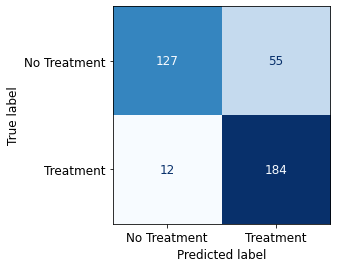

In [245]:
#Get the predictions
dt_predications = dt_random_search.predict(X_test)
#Add to the score card
update_score_card("Decision Tree",y_test,dt_predications)
#Get the confusion matrix
dt_cm = confusion_matrix(y_test, dt_predications)
plt.rc('font', size=12) 
ConfusionMatrixDisplay(dt_cm, display_labels=["No Treatment", "Treatment"]).plot(cmap=plt.cm.Blues,colorbar=False)

### Random Forest Model

### Model Training

In [246]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe = Pipeline(steps=[('col_trans',col_transformer),('rf', RandomForestClassifier())])
rng = range(5,101,5)
rf_param_grid = {
    "rf__n_estimators": rng,
    "rf__criterion": ['gini','entropy'],
    "rf__max_depth": rng,
    "rf__max_features": rng,
    "rf__min_samples_split": rng,
    "rf__min_samples_leaf": rng
}

In [247]:
rf_random_search = RandomizedSearchCV(rf_pipe,param_distributions=rf_param_grid,n_jobs=-1,scoring=['f1','recall'],cv=10,return_train_score=True,refit='f1')
rf_random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                    

#### Random Forest Model Training Score

In [248]:
HTML(pd.DataFrame(rf_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall",
 "mean_test_f1", "mean_train_f1"]].sort_values(by=['mean_test_f1','mean_test_recall'], ascending=False).head(10).to_html())

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1
3,"{'rf__n_estimators': 85, 'rf__min_samples_split': 30, 'rf__min_samples_leaf': 10, 'rf__max_features': 25, 'rf__max_depth': 70, 'rf__criterion': 'entropy'}",0.93,0.94,0.86,0.87
0,"{'rf__n_estimators': 95, 'rf__min_samples_split': 70, 'rf__min_samples_leaf': 90, 'rf__max_features': 75, 'rf__max_depth': 65, 'rf__criterion': 'gini'}",NaN,NaN,NaN,NaN
1,"{'rf__n_estimators': 35, 'rf__min_samples_split': 80, 'rf__min_samples_leaf': 45, 'rf__max_features': 45, 'rf__max_depth': 45, 'rf__criterion': 'entropy'}",NaN,NaN,NaN,NaN
2,"{'rf__n_estimators': 5, 'rf__min_samples_split': 60, 'rf__min_samples_leaf': 95, 'rf__max_features': 100, 'rf__max_depth': 30, 'rf__criterion': 'gini'}",NaN,NaN,NaN,NaN
4,"{'rf__n_estimators': 85, 'rf__min_samples_split': 35, 'rf__min_samples_leaf': 95, 'rf__max_features': 70, 'rf__max_depth': 35, 'rf__criterion': 'gini'}",NaN,NaN,NaN,NaN
5,"{'rf__n_estimators': 95, 'rf__min_samples_split': 50, 'rf__min_samples_leaf': 75, 'rf__max_features': 80, 'rf__max_depth': 60, 'rf__criterion': 'entropy'}",NaN,NaN,NaN,NaN
6,"{'rf__n_estimators': 75, 'rf__min_samples_split': 40, 'rf__min_samples_leaf': 95, 'rf__max_features': 85, 'rf__max_depth': 50, 'rf__criterion': 'gini'}",NaN,NaN,NaN,NaN
7,"{'rf__n_estimators': 65, 'rf__min_samples_split': 65, 'rf__min_samples_leaf': 55, 'rf__max_features': 50, 'rf__max_depth': 75, 'rf__criterion': 'entropy'}",NaN,NaN,NaN,NaN
8,"{'rf__n_estimators': 60, 'rf__min_samples_split': 45, 'rf__min_samples_leaf': 80, 'rf__max_features': 55, 'rf__max_depth': 10, 'rf__criterion': 'entropy'}",NaN,NaN,NaN,NaN
9,"{'rf__n_estimators': 70, 'rf__min_samples_split': 25, 'rf__min_samples_leaf': 10, 'rf__max_features': 90, 'rf__max_depth': 35, 'rf__criterion': 'gini'}",NaN,NaN,NaN,NaN


#### Random Forest Validation

##### Random Forest Test Scores

In [249]:
rf_cr = classification_report(
        y_test,
        rf_random_search.predict(X_test),
        target_names=["no treatment", "treatment"]
    )
print(rf_cr)

              precision    recall  f1-score   support

no treatment       0.88      0.71      0.79       182
   treatment       0.77      0.91      0.84       196

    accuracy                           0.81       378
   macro avg       0.83      0.81      0.81       378
weighted avg       0.82      0.81      0.81       378



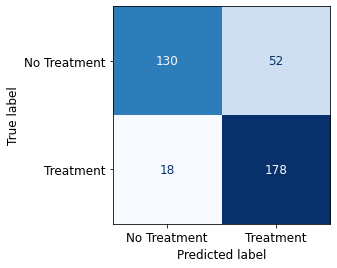

In [250]:
rf_predications = rf_random_search.predict(X_test)
update_score_card("Random Forest",y_test,rf_predications)
rf_cm = confusion_matrix(y_test, rf_predications)
plt.rc('font', size=12) 
ConfusionMatrixDisplay(rf_cm, display_labels=["No Treatment", "Treatment"]).plot(cmap=plt.cm.Blues,colorbar=False)

## Comparing the  performance of the 6 models

### Score

In [251]:
score_card.sort_values(by='Recall Score',ascending=False).reset_index(drop=True)

,Model,Recall Score,f1-score
0,Decision Tree,0.94,0.85
1,SVC,0.91,0.84
2,Logistic Backward Regression,0.91,0.84
3,Random Forest,0.91,0.84
4,Logistic Regression,0.89,0.84
5,KNN,0.84,0.81


The results are close to the results we obtained from the cross-validation scores.

In [252]:
#one table output
results_df = pd.DataFrame(dt_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall","mean_test_f1", "mean_train_f1"]]
results_df = results_df.append(pd.DataFrame(knn_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall","mean_test_f1", "mean_train_f1"]])
results_df = results_df.append(pd.DataFrame(logis_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall","mean_test_f1", "mean_train_f1"]])
results_df = results_df.append(pd.DataFrame(logis_bfs_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall","mean_test_f1", "mean_train_f1"]])
results_df = results_df.append(pd.DataFrame(svc_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall","mean_test_f1", "mean_train_f1"]])
results_df = results_df.append(pd.DataFrame(rf_random_search.cv_results_)[["params", "mean_test_recall", "mean_train_recall","mean_test_f1", "mean_train_f1"]])
HTML(results_df.sort_values(by=['mean_test_f1',"mean_test_recall"], ascending=(False)).head(10).to_html())

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1
3,"{'rf__n_estimators': 85, 'rf__min_samples_split': 30, 'rf__min_samples_leaf': 10, 'rf__max_features': 25, 'rf__max_depth': 70, 'rf__criterion': 'entropy'}",0.93,0.94,0.86,0.87
7,"{'lr__C': 0.0001, 'feature_selector__n_features_to_select': 5}",0.92,0.92,0.86,0.85
1,"{'svc__kernel': 'rbf', 'svc__gamma': 0.01, 'svc__degree': 3, 'svc__C': 1.1}",0.92,0.93,0.85,0.86
4,"{'svc__kernel': 'sigmoid', 'svc__gamma': 0.001, 'svc__degree': 2, 'svc__C': 0.9}",0.92,0.92,0.85,0.86
2,"{'svc__kernel': 'sigmoid', 'svc__gamma': 0.01, 'svc__degree': 2, 'svc__C': 1.2}",0.91,0.92,0.85,0.86
6,"{'lr__C': 0.001, 'feature_selector__n_features_to_select': 5}",0.90,0.91,0.85,0.86
2,"{'lr__C': 1.0, 'feature_selector__n_features_to_select': 3}",0.90,0.91,0.85,0.85
9,"{'lr__C': 10.0, 'feature_selector__n_features_to_select': 3}",0.90,0.91,0.85,0.85
2,{'lr__C': 0.0001},0.90,0.91,0.85,0.85
0,"{'lr__C': 0.01, 'feature_selector__n_features_to_select': 3}",0.90,0.90,0.85,0.85


### Confusion Matrix

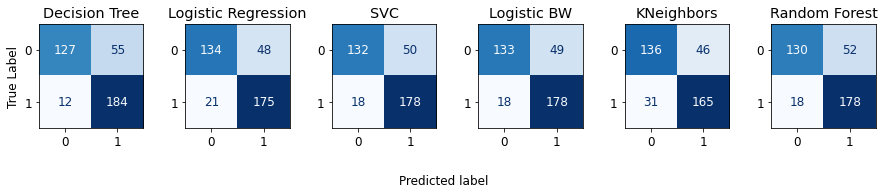

In [253]:
def plot_confusion_mtcs(plt_ax, cm, title,ylab=''):
    dt_cm = ConfusionMatrixDisplay(cm,display_labels=['0','1'])
    dt_cm.plot(ax= plt_ax,cmap=plt.cm.Blues)
    dt_cm.ax_.set_title(title)
    dt_cm.ax_.set_xlabel('')
    dt_cm.ax_.set_ylabel(ylab)
    dt_cm.im_.colorbar.remove()
    
fig, (ax_dt,ax_lg,ax_svc,ax_lgbw,ax_knn,ax_rf) = plt.subplots(1,6)
plot_confusion_mtcs(ax_dt,dt_cm,"Decision Tree",'True Label')
plot_confusion_mtcs(ax_lg,logis_cm,"Logistic Regression")
plot_confusion_mtcs(ax_svc,svc_cm,"SVC")
plot_confusion_mtcs(ax_lgbw,logis_bw_cm,"Logistic BW")
plot_confusion_mtcs(ax_knn,knn_cm,"KNeighbors")
plot_confusion_mtcs(ax_rf,rf_cm,"Random Forest")
fig.text(0.5, 0.2, 'Predicted label', ha='center')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
fig.set_size_inches(15,5)
fig.show()

## Conclusion

In total, we've trained 6 classification algorithms in order to be able to predict if the employee will seek mental health treatment. For each model, we performed a random search on the relevant hyperparameters to tune our model and get optimal results from each one. 

We used the f1-score (i.e. harmonic mean) and recall to measure the performance of the models and to minimize the misclassification of people who would seek treatment.